Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

Algorithm

In [2]:
class FilterSimulation():

    def terminate(self, waveform): #deduplicate values
        waveform = np.asarray(waveform)
        return waveform[np.insert(waveform[1:] != waveform[:-1], 0, True)]

    def setup(self, time_array, waveform, compression, num_samples, CONSTANT_PADDING):
        dense_time = np.linspace(0, time_array[-1], num_samples) # creates time axis from 0 to 1 with 250,000 samples
        dense_waveform = np.interp(dense_time, time_array / compression, waveform) # (x coordinates to evaluate values, compressed time array, waveform)

        original_sliced = self.terminate(dense_waveform)
        original = np.pad(original_sliced, pad_width=CONSTANT_PADDING, mode='edge')

        time_sliced = dense_time[:len(original)] #shorten time to match sliced
        dt = time_sliced[1] - time_sliced[0] # time difference between 2 samples
        time = np.arange(len(original)) * dt # constructs time array of original length with samples dt apart

        first_index = original[0]
        last_index = float(original[-1])
        
        return original, time, dt, first_index, last_index
    
    def filter(self):
        step_response = np.load('filter_data.npy')
        impulse_response = np.diff(step_response, prepend = 0)
        return impulse_response

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='cubic', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated_filtered):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated_filtered, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Lowpass-Filter Response')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, last_index):
        impulse_response = self.filter()

        # ir_padded = np.pad(impulse_response, (300, len(waveform)),  mode='constant')
        # waveform_padded = np.pad(waveform, (300, len(impulse_response)), mode='constant', constant_values = last_index)

        total_length = len(impulse_response) + len(waveform)
        ir_padded = np.pad(impulse_response, (300, total_length - len(impulse_response) - 300), mode='constant')
        waveform_padded = np.pad(waveform, (300, total_length - len(waveform) - 300), mode='constant', constant_values=last_index)

        G = fft(ir_padded)
        h_t = waveform_padded
        h_w = fft(h_t) #input waveform h(t)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        eps = 1e-4
        reg_strength = eps * np.max(G_magnitude)**2

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg_strength) #does not al
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        f_w = h_w * regularized_G
        f_t = np.real(ifft(f_w))

        return f_t

    def trimming(self, precompensated, CONSTANT_PADDING, first_index, last_index):
        for i in range(0, int(CONSTANT_PADDING*0.6)):
            precompensated[i] = first_index
        for i in range(len(precompensated) - int(CONSTANT_PADDING*2.4), len(precompensated)):
            precompensated[i] = last_index
        return precompensated

Use Case

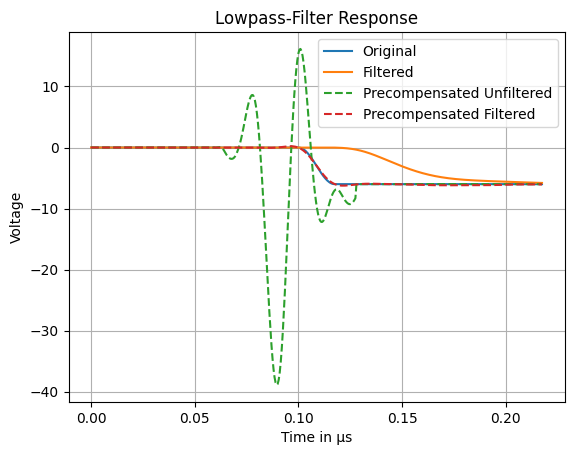

In [3]:
compression = 1000 # manual value
num_samples = 35000 # manual value
CONSTANT_PADDING = 200 # manual value

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array, waveform, compression, num_samples, CONSTANT_PADDING)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
precompensated = FilterSimulation().trimming(precompensated, CONSTANT_PADDING, first_index, last_index)


precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# Scale to correct values:
time *= 17.5        
original *= -6   
filtered *= -6
precompensated_unfiltered *= -6
precompensated_filtered *= -6

FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)